In [12]:
import pandas as pd
import numpy as np
import os

os.chdir("../Data")

from DataHelper import *

# 1.0 Merge Energy Dataset and Weather Features

In [13]:
df1 = pd.read_csv("energy_dataset_clean.csv")
df2 = pd.read_csv("weather_features_clean.csv")
df = merge_energy_weather(df1, df2)

TARGET = "total load actual"
df = df.reindex(columns = [TARGET] +  list(df.loc[:, df.columns != TARGET].columns))

df.sort_index(inplace=True)
any_zero_columns = df.columns[(df == 0).all()].tolist()
if len(any_zero_columns) > 0:
    print("Features with only zeros:", any_zero_columns)
    df.drop(columns=any_zero_columns, inplace=True)

print("Merged data (Number of rows, Number of features): ", df.shape)
print(df.columns)
print(time_spacing(df))
print("Is there any missing data: ", missing_features(df).any().any())


Features with only zeros: ['snow_3h_Barcelona', 'snow_3h_Seville']
Merged data (Number of rows, Number of features):  (35064, 63)
Index(['total load actual', 'generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'temp_Barcelona',
       'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'clouds_all_Barcelona', 'temp_Bilbao',
       'temp_min_Bilbao', 'temp_max_Bilbao', 'pressure_Bilbao',
       'humidity_Bilbao', 'wind_speed_Bilbao', 'wind_deg_Bilbao',
       'rain_1h_Bil

# 2.0 Feature Generation

In [14]:
original_columns, numerical_features = df.columns.to_list(), df.columns.to_list()
binary_features, cyclical_features = [], []

We will start by adding cyclically encoded time-based features to our dataset, including hour, month, and season. These features are crucial as they capture the inherent periodicity in time-based data, which is especially relevant for analyzing patterns in energy consumption and weather data. By incorporating these cyclic features, we enhance the representation of repeating patterns observed in the raw time-based variables, thereby improving the model's ability to learn from temporal trends.

In [15]:
current_columns = original_columns.copy()
df = add_time_features(df, True)
df = add_seasons(df, True)
new_columns = list(set(df.columns) - set(current_columns))
cyclical_features += new_columns
print("The new time-based features added: " , sorted(new_columns))

The new time-based features added:  ['hour_cos', 'hour_sin', 'month_cos', "month_sin'", 'season_cos', 'season_sin']


In [16]:
df.describe().round(3)

,total load actual,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia,hour_sin,hour_cos,month_sin',month_cos,season_sin,season_cos
count,35064.000,35064.000,35064.000,35064.000,35064.000,35064.000,35064.000,35064.000,35064.000,35064.000,...,35064.000,35064.000,35064.000,35064.000,35064.000,35064.000,35064.000,35064.000,35064.000,35064.000
mean,28697.215,383.540,448.092,5622.180,4256.120,298.317,475.635,972.190,2605.543,6264.187,...,160.802,0.034,0.000,20.740,0.500,0.500,0.498,0.499,0.498,0.499
std,4574.967,85.348,354.617,2201.569,1961.719,52.513,792.410,400.723,1835.074,839.643,...,120.413,0.264,0.012,25.604,0.354,0.354,0.353,0.354,0.353,0.354
min,18041.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,24808.750,333.000,0.000,4126.000,2527.000,263.000,0.000,637.000,1078.000,5761.000,...,50.000,0.000,0.000,0.000,0.146,0.146,0.067,0.067,0.000,0.000
50%,28902.000,367.000,509.000,4969.000,4474.000,300.000,68.000,906.000,2165.000,6568.500,...,130.000,0.000,0.000,20.000,0.500,0.500,0.500,0.500,0.500,0.500
75%,32191.250,433.000,757.000,6428.000,5839.000,330.000,616.000,1250.000,3758.000,7025.000,...,280.000,0.000,0.000,20.000,0.854,0.854,0.750,0.933,0.500,0.500
max,41015.000,592.000,999.000,20034.000,8359.000,449.000,4523.000,2000.000,9728.000,7117.000,...,360.000,12.000,1.125,100.000,1.000,1.000,1.000,1.000,1.000,1.000


Next, we will add features that include binary values (0, 1) to indicate holidays and weekdays for each hourly period.

In [17]:
current_columns += new_columns
df = is_holidays(df, df.index.year.unique())
df = is_weekday(df)
new_columns = list(set(df.columns) - set(current_columns))
binary_features += new_columns
print("The new features added: ", sorted(new_columns))

The new features added:  ['isHoliday', 'isWeekday']


Next, concerning business hours, we have determined that this could be a valuable feature when analyzing the energy dataset. To reiterate, in Spain, typical business hours are from approximately 8:30 AM to 1:30 PM, followed by a break, and then from 4:30 PM to around 8:00 PM.

For our analysis, we define the following in this column:
- Business Hours ; If hour $\gt$ 8am and hour $\lt$ 2pm or hour $\gt$ 4pm and hour $\lt$ 8pm as during business hours
- Siesta ; If hour $\ge$ 2pm and $\le$ 4pm as Siesta
- After Business Hours ; For after business hours

We will introduce three new binary features to indicate the time of day based on the logic described above.

In [18]:
current_columns += new_columns
df = add_business_hours(df, True)
new_columns = list(set(df.columns) - set(current_columns))
binary_features += new_columns
print("The new features added: ",  sorted(new_columns))

The new features added:  ['is_after_business_hours', 'is_business_hours', 'is_siesta']


Now, let's add the lag features for our target variable, specifically for 1 hour and 24 hours.

In [19]:
current_columns += new_columns
df = add_lags_by_hours(df, TARGET, [1, 24])
new_columns = list(set(df.columns) - set(current_columns))
numerical_features += new_columns
print("The new features added: ", sorted(new_columns))

The new features added:  ['lag_1 total load actual', 'lag_24 total load actual']


Based on the analysis of the weather dataset, we identified that time-based features such as the hour of the day, day of the week, and season or month can be quite useful. These features have already been incorporated into the dataset. Additionally, with respect to temperature, we concluded that adding an hourly range, calculated as the absolute difference between maximum and minimum temperatures, could be valuable. This feature helps in understanding the variability in temperature within a day.

In [20]:
current_columns += new_columns
df = add_temp_ranges(df, list(df2["city_name"].unique()))
new_columns = list(set(df.columns) - set(current_columns))
numerical_features += new_columns
for i in new_columns:
    print(i)
    print(f"Biggest change is {np.max(df[i])} and the Smallest change is {np.min(df[i])}.")
print("The new features added: ", sorted(new_columns))

temp_range_Seville
Biggest change is 29.0 and the Smallest change is 0.0.
temp_range_Madrid
Biggest change is 31.0 and the Smallest change is 0.0.
temp_range_Barcelona
Biggest change is 33.33000000000004 and the Smallest change is 0.0.
temp_range_Bilbao
Biggest change is 19.439999999999998 and the Smallest change is 0.0.
temp_range_Valencia
Biggest change is 18.53000000000003 and the Smallest change is 0.0.
The new features added:  ['temp_range_Barcelona', 'temp_range_Bilbao', 'temp_range_Madrid', 'temp_range_Seville', 'temp_range_Valencia']


Next, we will introduce interaction features by combining temperature and humidity variables. This approach could help capture the combined effects of these variables on our target variable. By creating these interaction terms, we aim to better understand how the joint influence of temperature and humidity impacts the target, potentially revealing patterns that may not be apparent when examining each feature individually.

In [21]:
# Removed 
current_columns += new_columns
df = add_interaction_pairs(df, "temp", "humidity", list(df2["city_name"].unique()))
new_columns = list(set(df.columns) - set(current_columns))
numerical_features += new_columns
print("The new features added: ", sorted(new_columns))

The new features added:  ['temp_x_humidity_Barcelona', 'temp_x_humidity_Bilbao', 'temp_x_humidity_Madrid', 'temp_x_humidity_Seville', 'temp_x_humidity_Valencia']


Lastly, based on our examination of the weather features, we will introduce features to detect anomalies in temperature, pressure, and humidity on an hourly basis for each season. These features will help identify unusual patterns that may indicate significant deviations from the norm for each city.

In [22]:
temp_features = ["temp_Barcelona", "temp_Bilbao", "temp_Madrid", "temp_Seville", "temp_Valencia"]
pressure_features = ['pressure_Valencia', 'pressure_Madrid', 'pressure_Bilbao', 'pressure_Barcelona', 'pressure_Seville']
humid_features = ['humidity_Valencia', 'humidity_Madrid', 'humidity_Bilbao', 'humidity_Barcelona', 'humidity_Seville']

current_columns += new_columns
anomaly_columns = temp_features  + pressure_features + humid_features
df = is_anomaly_by_season_hour(df, anomaly_columns)
new_columns = list(set(df.columns) - set(current_columns))
binary_features += new_columns
for i in new_columns:
    print(i)
    print(f"The number of anomalies detected through the entire time series is {df[i].sum()}.")
print("The new features added: ", new_columns)

temp_Seville_anomalies
The number of anomalies detected through the entire time series is 1458.0.
pressure_Barcelona_anomalies
The number of anomalies detected through the entire time series is 2843.0.
humidity_Seville_anomalies
The number of anomalies detected through the entire time series is 2177.0.
temp_Valencia_anomalies
The number of anomalies detected through the entire time series is 1784.0.
pressure_Seville_anomalies
The number of anomalies detected through the entire time series is 2299.0.
humidity_Barcelona_anomalies
The number of anomalies detected through the entire time series is 1612.0.
humidity_Bilbao_anomalies
The number of anomalies detected through the entire time series is 1665.0.
humidity_Valencia_anomalies
The number of anomalies detected through the entire time series is 2206.0.
temp_Bilbao_anomalies
The number of anomalies detected through the entire time series is 1485.0.
temp_Madrid_anomalies
The number of anomalies detected through the entire time series is 1

Now that we have generated all the additional features deemed potentially valuable from our analysis of the energy dataset and weather features, let's move on to feature selection.

In [12]:
qualitative_features = binary_features + cyclical_features
save_file(df, "Selected_Features/raw_all_features_dataset.csv")

File is saved.


# 3.0 Feature Selection

For feature selection, we will explore three approaches: Random Forest Classification, Lasso Regularization, and Principal Component Analysis (PCA).

To start, let's examine the target variable ('total load actual') through its ACF and PACF plots.

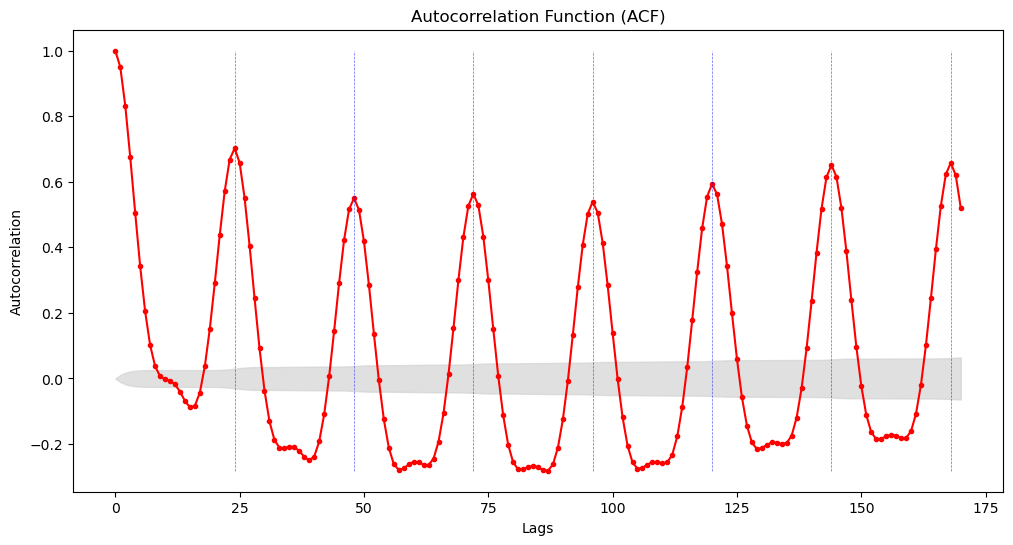

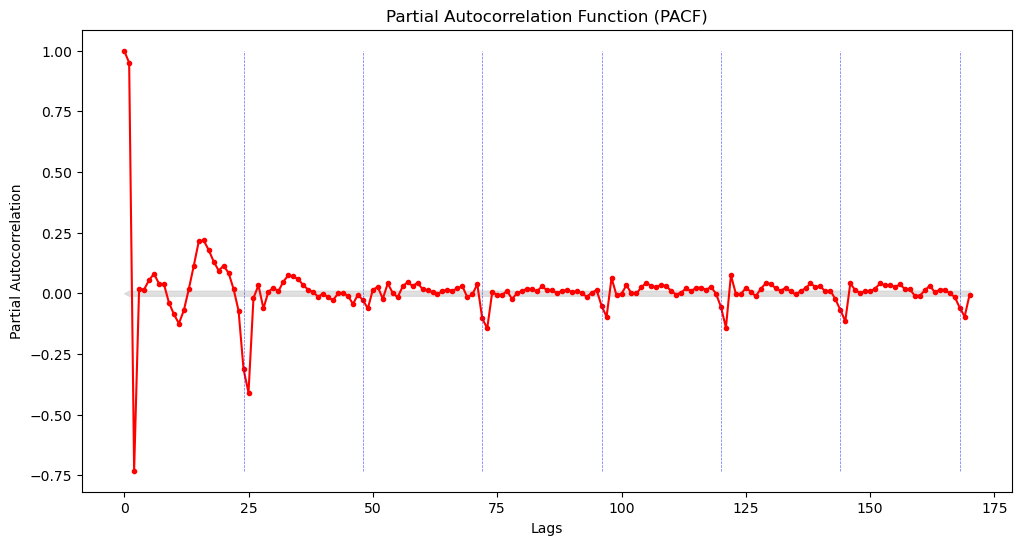

In [13]:
plot_acf(df, TARGET, 170, True)
plot_pacf(df, TARGET, 170, True)

**Note:** The training set will consist of the first 80% of data in our timeseries.

As we plan on applying Lasso and PCA, let's create a dataset that transforms our target variable into a stationary time series. We will apply a shifted log transformation followed by first differencing. For simplicity, we will also apply these transformations to the other numerical features.

File is saved.


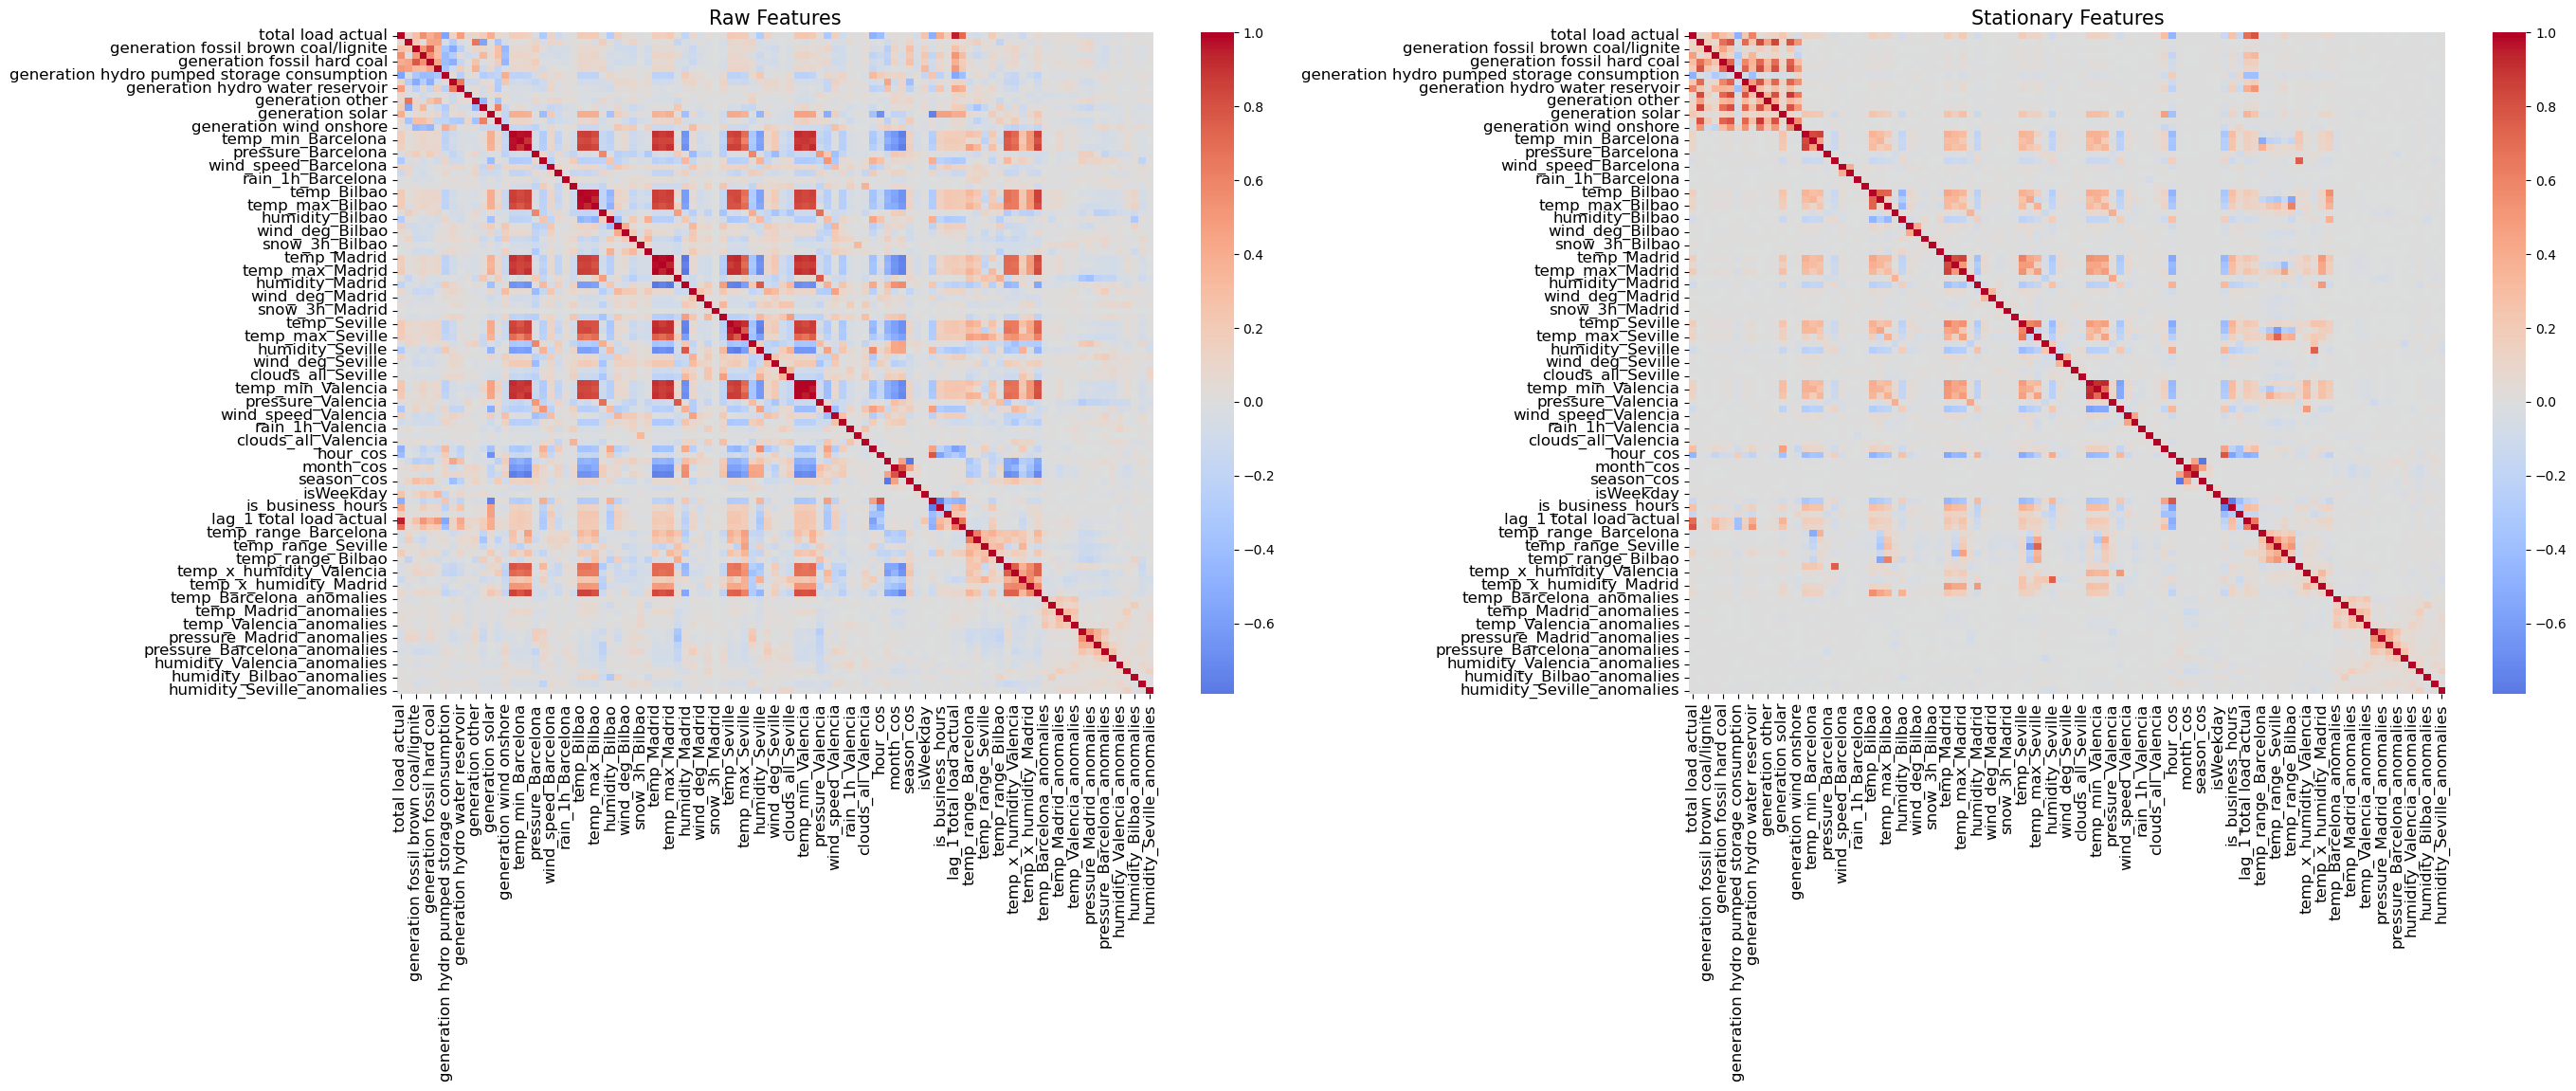

In [14]:
stationary_data = df_stationary(df, numerical_features, qualitative_features)
save_file(stationary_data, "Selected_Features/stationary_all_features_dataset.csv")
plot_corr_comp(df, stationary_data, "Raw Features", "Stationary Features")

From our analysis of the energy dataset, we observed that even after transforming our target variable into a stationary time series, it still exhibited strong seasonality. From the plots, when considering the linear relationships between the features, we can see for the most part that after stationarization, the features become less correlated with one another. These results suggest that we should stationarize our features before using Lasso and PCA for feature selection. For Lasso, stationarizing helps reduce multicollinearity and ensures that feature selection is based on meaningful relationships rather than capturing noise from trends or seasonality. Similarly, for PCA, stationarizing allows the principal components to represent more stable, underlying patterns instead of being dominated by the variance introduced by time-based effects. Therefore, applying stationarity transformations to your data before using Lasso and PCA will likely result in more interpretable and robust feature selection, as it mitigates the influence of trends and seasonality.

In [15]:
all_correlations = df.corr()
strong_correlations = abs(all_correlations[all_correlations > 0.8])
print(strong_correlations[strong_correlations < 1].stack().to_string())

total load actual        lag_1 total load actual    0.950483
temp_Barcelona           temp_min_Barcelona         0.970264
                         temp_max_Barcelona         0.976904
                         temp_Bilbao                0.866727
                         temp_min_Bilbao            0.867970
                         temp_max_Bilbao            0.828347
                         temp_Madrid                0.903996
                         temp_min_Madrid            0.874548
                         temp_max_Madrid            0.899010
                         temp_Seville               0.841910
                         temp_min_Seville           0.863566
                         temp_Valencia              0.917506
                         temp_min_Valencia          0.898616
                         temp_max_Valencia          0.913727
                         temp_x_humidity_Bilbao     0.847286
temp_min_Barcelona       temp_Barcelona             0.970264
                        

Based on the correlation results above, we will create a new dataset by removing the following features: 'temp_Barcelona', 'temp_max_Barcelona', 'temp_Bilbao', 'temp_min_Bilbao', 'temp_Madrid', 'temp_min_Madrid', 'temp_max_Madrid', 'temp_min_Seville', 'temp_Valencia', 'temp_min_Valencia', 'temp_max_Valencia', 'temp_max_Bilbao', 'temp_Seville', 'lag_1 total load actual'

These features were selected to balance the removal of the most correlated ones without removing too many features at once.

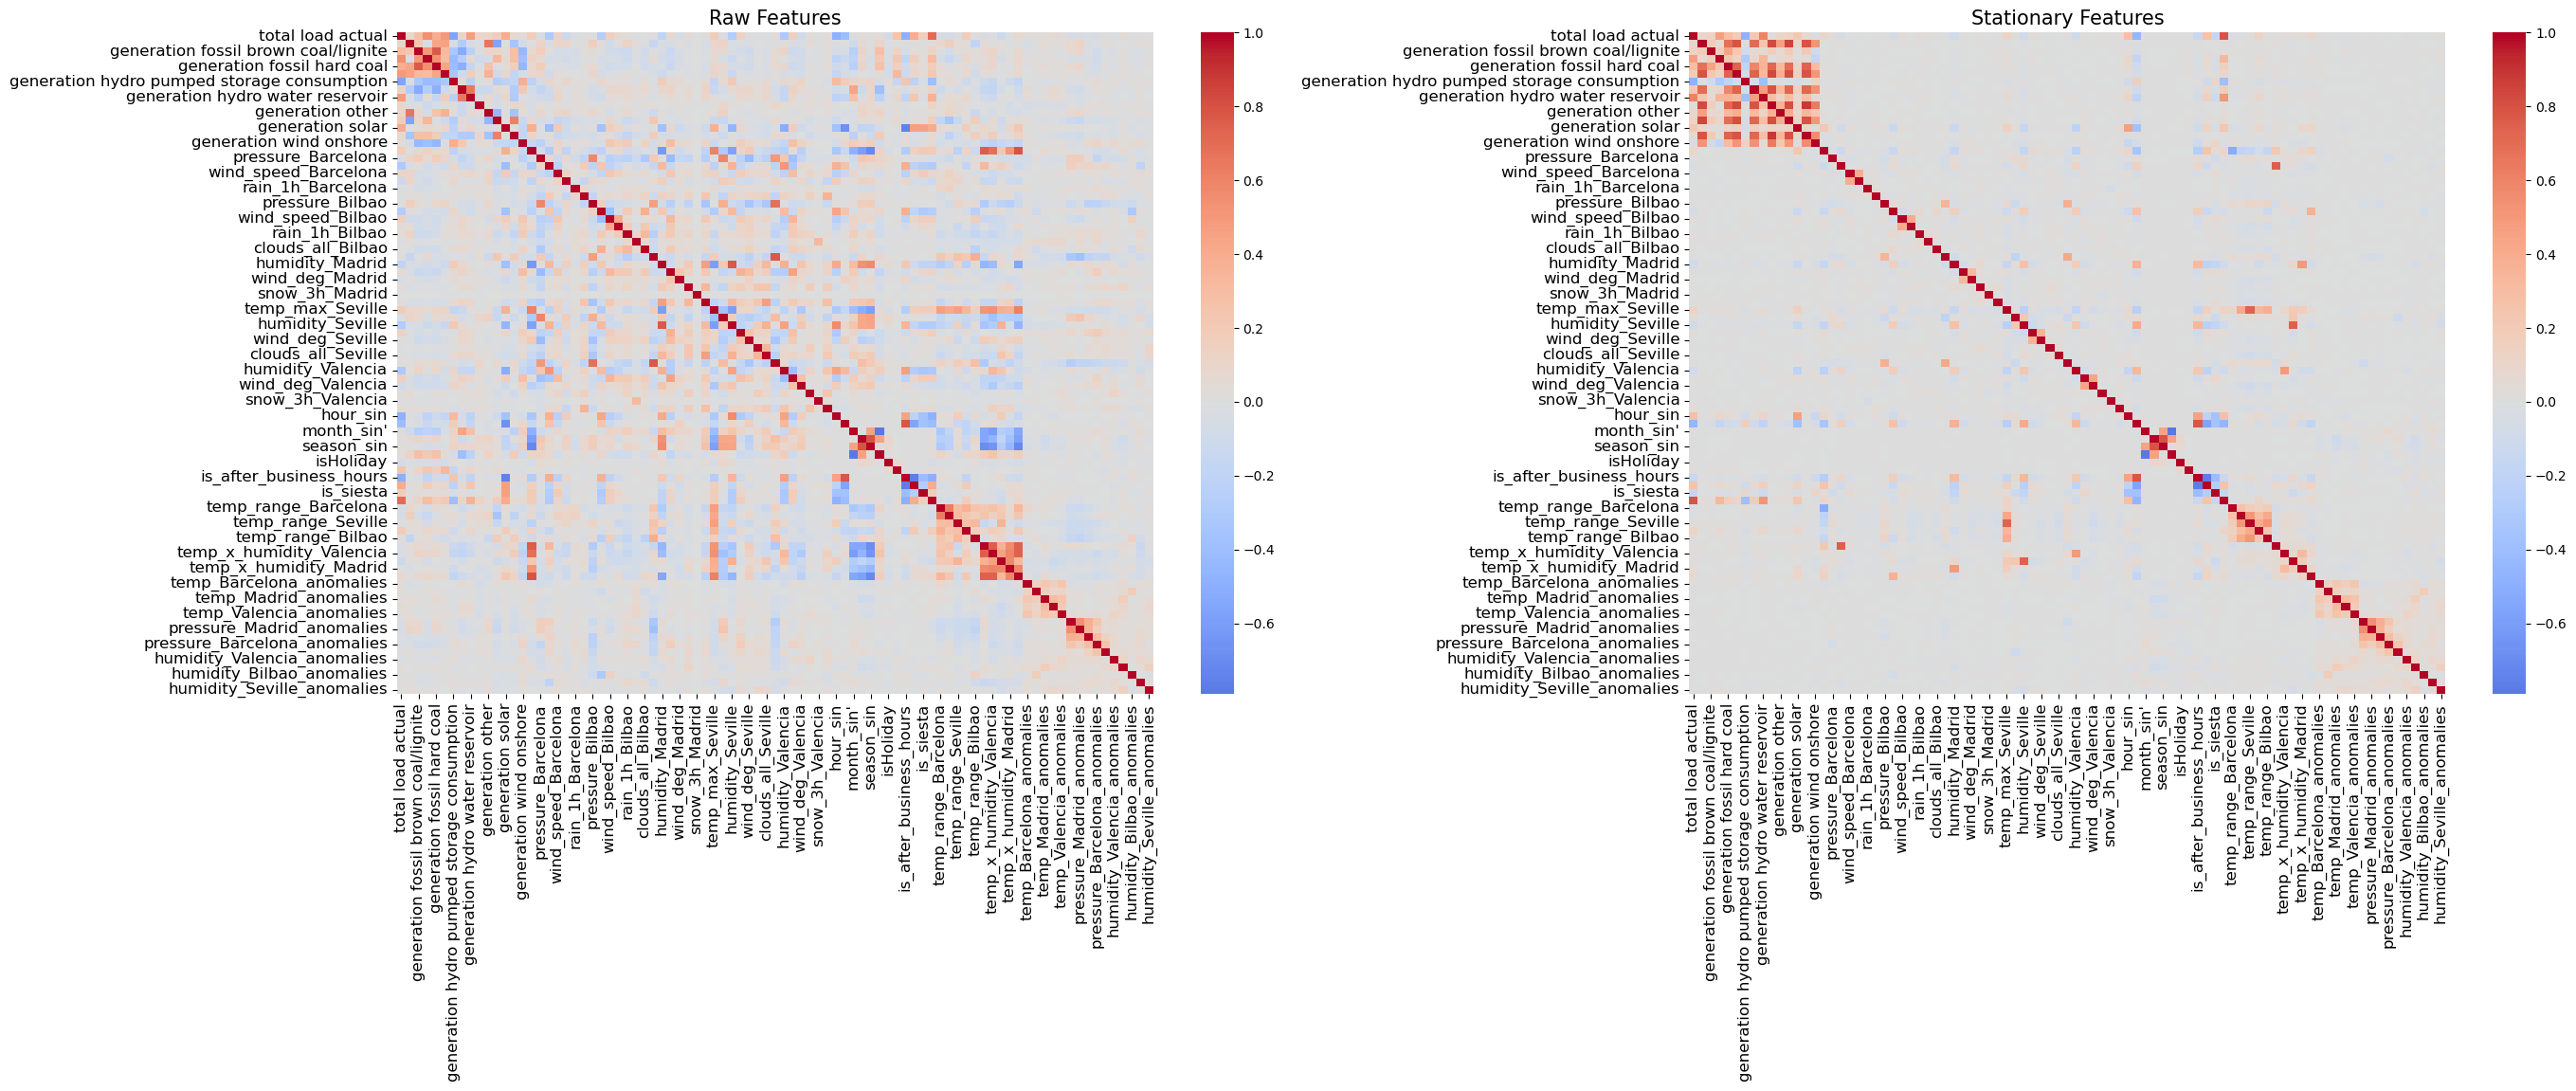

In [16]:
features_to_remove = ['temp_Barcelona', 'temp_max_Barcelona', 'temp_Bilbao', 'temp_min_Bilbao',
                      'temp_Madrid', 'temp_min_Madrid', 'temp_max_Madrid', 'temp_min_Seville',
                      'temp_Valencia', 'temp_min_Valencia', 'temp_max_Valencia', 'temp_max_Bilbao',
                      'temp_Seville', 'lag_1 total load actual']
df2 = df.copy()
df2.drop(columns=features_to_remove, inplace=True)
stationary_data2 = stationary_data.copy()
stationary_data2.drop(columns=features_to_remove, inplace=True)

plot_corr_comp(df2, stationary_data2, "Raw Features", "Stationary Features")

## 3.1 XGBoost Regressor

**Overview:**

When using the XGBoost Regressor for feature selection, we will apply it to our raw dataset (i.e., no transformations or scaling), as it is not sensitive to the scale of features. We will split the data into training and validation sets using TimeSeriesSplit, ensuring that the model respects the temporal order of the data. We will implement walk-forward cross-validation with 10 folds, given that we have over 35,000 rows, using test sizes that cover 2 days. This approach will hopefully allow the model to generalize better and capture repeating seasonal patterns (e.g., 48 hours), while incorporating a 5-hour gap to avoid data leakage, as indicated by the PACF. We will tune the model’s hyperparameters—specifically, the number of trees (n_estimators), tree depth (max_depth), and learning rate—using GridSearchCV. After determining the optimal parameters, we will refit the model on the entire training set, allowing the model to automatically adjust the number of trees. Finally, we will calculate and rank the feature importances based on the trained model, enabling us to select the most relevant features for future modeling or analysis.

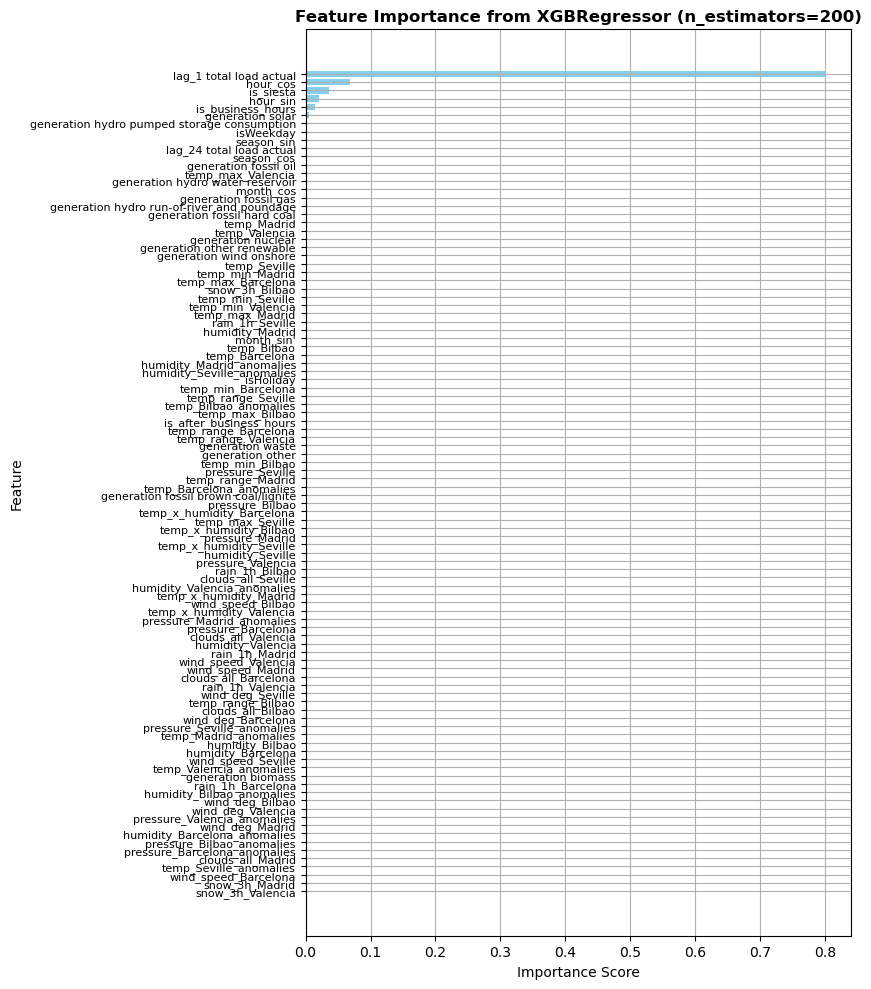

---------- XGBoost Cross Validation ---------- 

Best n_estimators from CV: 200 

Best max_depth from CV: 10 

Best learning_rate from CV: 0.05 

XGBRegressor CV Model Loss Metrics: 

             MSE        RMSE
0  249904.844649  499.904836


In [17]:
xgb_param_grid = {"n_estimators": [50, 100, 150, 200], "max_depth": [10, 20, 30], "learning_rate": [0.01, 0.05, 0.1]}
tss_params = {"n_splits": 10, "test_size": 48, "gap": 5}
train_data, test_data = train_test_split(df, df.index)
feature_importance_df, n_estimators, max_depth, learning_rate, cv_xgb_results = xgb_feature_importance(train_data, test_data, TARGET, xgb_param_grid, tss_params)

From the results above, the loss metrics are relatively high, indicating that the model is not performing well. The feature importance plot reveals that the model heavily relies on the target variable's lag 1 feature, suggesting it struggles to generalize effectively. Let's rerun cross-validation on the dataset where we accounted for strong correlations.

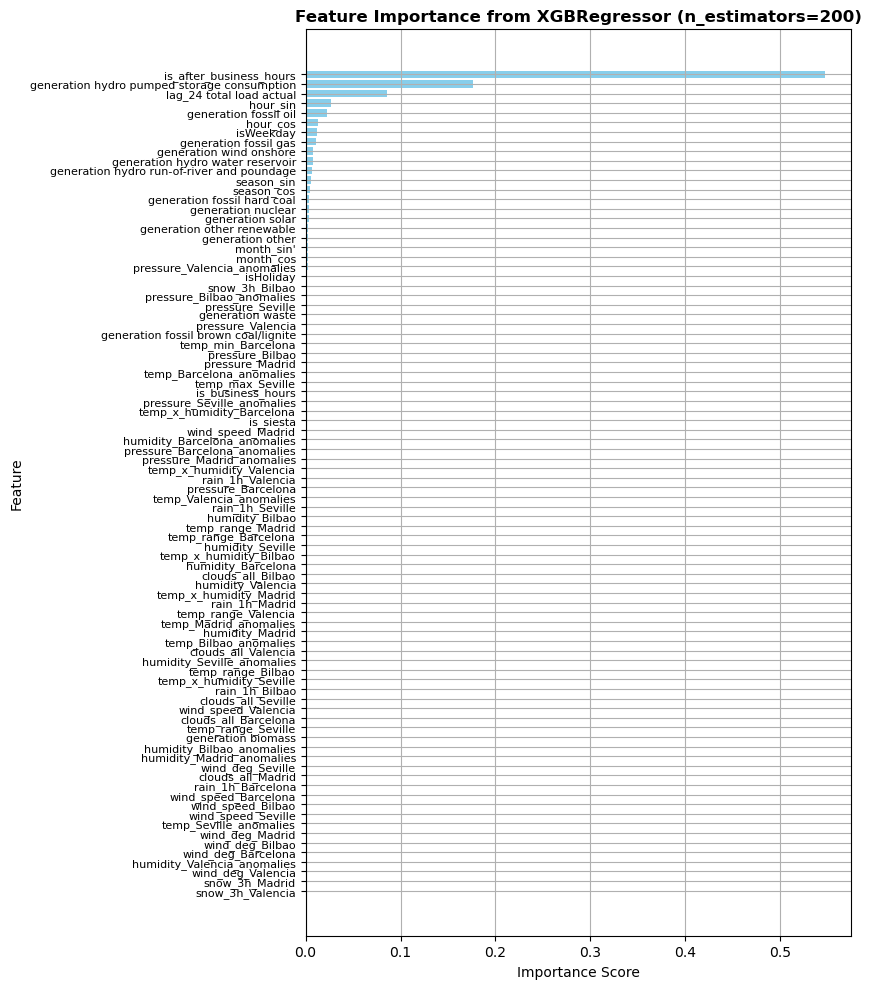

---------- XGBoost Cross Validation ---------- 

Best n_estimators from CV: 200 

Best max_depth from CV: 10 

Best learning_rate from CV: 0.05 

XGBRegressor CV Model Loss Metrics: 

            MSE         RMSE
0  1.897977e+06  1377.670682


In [18]:
train_data2, test_data2 = train_test_split(df2, df.index)
feature_importance_df2, n_estimators2, max_depth2, learning_rate2, cv_xgb_results2 = xgb_feature_importance(train_data2, test_data2, TARGET, xgb_param_grid, tss_params)

In [19]:
reduced_features = [TARGET] + feature_importance_df2[feature_importance_df2["Importance"] > 0.1]["Feature"].tolist()
rf_results, rf_features = xgb_evaluate_model(train_data2, test_data2, TARGET, n_estimators2, max_depth2, learning_rate2, reduced_features)

------------ XGBoost Final Results ------------ 

Selected Important Features: ['total load actual', 'is_after_business_hours', 'generation hydro pumped storage consumption'] 

XGBoost Final Loss Metrics: 

            MSE         RMSE
0  1.034910e+07  3217.002417


After adjusting the dataset by removing highly correlated features, the performance of the XGBoost Regressor remains poor. To potentially improve performance, several strategies could be employed, such as refining feature selection by applying PCA beforehand, expanding the ranges of hyperparameters for tuning, or incorporating L2 regularization alongside L1. However, due to limited time and resources, we will disregard further feature selection efforts at this stage and move on to the next methodology for feature selection.

## 3.2 Lasso

**Overview:**

When using Lasso Regularization for feature selection, we will apply it to our stationary dataset. Similar to our Random Forest Classifier, we will implement walk-forward cross-validation with the same parameters to determine the optimal alpha regularization parameter. After identifying the best alpha, a Lasso model will be refitted on the entire training dataset using this value, and the model's non-zero coefficients will be used to select the most important features.

In [20]:
alpha_grid = np.logspace(-6, 2, 100)
tss_params = {"n_splits": 10, "test_size": 48, "gap": 5}
train_data, test_data = train_test_split(stationary_data, df.index)
lasso_selected_features = lasso_feature_selection(train_data, test_data, TARGET, tss_params, stationary_data.columns.tolist(), alpha_grid)

---------- Lasso Cross Validation ---------- 

Best alpha: 1e-05 

Selected features: ['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation wind onshore', 'wind_speed_Barcelona', 'wind_deg_Barcelona', 'clouds_all_Barcelona', 'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao', 'wind_speed_Madrid', 'wind_deg_Madrid', 'clouds_all_Madrid', 'wind_speed_Seville', 'wind_deg_Seville', 'hour_sin', 'hour_cos', 'isHoliday', 'isWeekday', 'is_business_hours', 'is_siesta', 'lag_1 total load actual', 'lag_24 total load actual', 'temp_range_Barcelona', 'temp_range_Valencia', 'temp_range_Madrid', 'temp_range_Bilbao', 'temp_Barcelona_anomalies', 'temp_Madrid_anomalies', 'temp_Sevi

The Lasso cross-validation process selected an optimal alpha value of **2e-05**, resulting in the identification of **40 important features**. During cross-validation, the model achieved an MSE of **0.00038** and an RMSE of **0.019494**, indicating strong performance on the training data. However, when these selected features and the optimal alpha were applied to the test set, the model's performance deteriorated, with the MSE increasing to **0.005809** and the RMSE rising to **0.076217**. While the same **40 features** were selected consistently between cross-validation and test set evaluation, the significant difference in loss metrics suggests that the model does not generalize as well on unseen data and may have overfitted during cross-validation. This highlights the importance of potentially increasing the regularization strength or exploring other feature selection methods to improve the model's generalization ability.

Moving forward, let's use lasso regularization on the dataset wehere we accounted for strong correlations. 

In [21]:
train_data2, test_data2 = train_test_split(stationary_data2, df.index)
lasso_selected_features = lasso_feature_selection(train_data2, test_data2, TARGET, tss_params, stationary_data2.columns.tolist(), alpha_grid)

---------- Lasso Cross Validation ---------- 

Best alpha: 1e-05 

Selected features: ['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation nuclear', 'generation other', 'generation other renewable', 'generation wind onshore', 'wind_speed_Barcelona', 'wind_deg_Barcelona', 'humidity_Bilbao', 'rain_1h_Bilbao', 'pressure_Madrid', 'wind_speed_Madrid', 'wind_deg_Madrid', 'temp_max_Seville', 'humidity_Seville', 'wind_speed_Seville', 'wind_deg_Seville', 'rain_1h_Seville', 'clouds_all_Seville', 'pressure_Valencia', 'wind_speed_Valencia', 'wind_deg_Valencia', 'hour_sin', 'hour_cos', 'month_cos', 'isHoliday', 'isWeekday', 'is_after_business_hours', 'is_business_hours', 'is_siesta', 'lag_24 total load actual', 'temp_range_Barcelona', 'temp_range_Valencia', 'temp_range_M

Similar to the results from the XGB Regressor, using Lasso for feature selection yielded unfavorable outcomes. After accounting for highly correlated features, the model's performance seems to have deteriorated. This suggests that my approach to feature removal—focused on minimizing the number of features while eliminating those that exhibit high correlation—was not optimal. In other words, important information was likely lost in the process.

## 3.3 PCA

**Overview:**

After using Lasso for feature selection, many features were dropped, suggesting that some variables may not contribute meaningfully within a linear regression framework. However, Lasso's focus on purely linear relationships can overlook important features in more complex datasets, such as time series, where non-linear interactions and time-dependent patterns are prevalent. To better capture the underlying structure of the data, we turn to Principal Component Analysis (PCA). Although PCA also emphasizes linear combinations of features, it reduces dimensionality by retaining components that capture the most variance, rather than outright dropping features. This ensures that critical information is preserved while simplifying the dataset, making it particularly suitable for complex tasks like total load forecasting, where key features may not be immediately obvious and non-linear dynamics play a significant role.

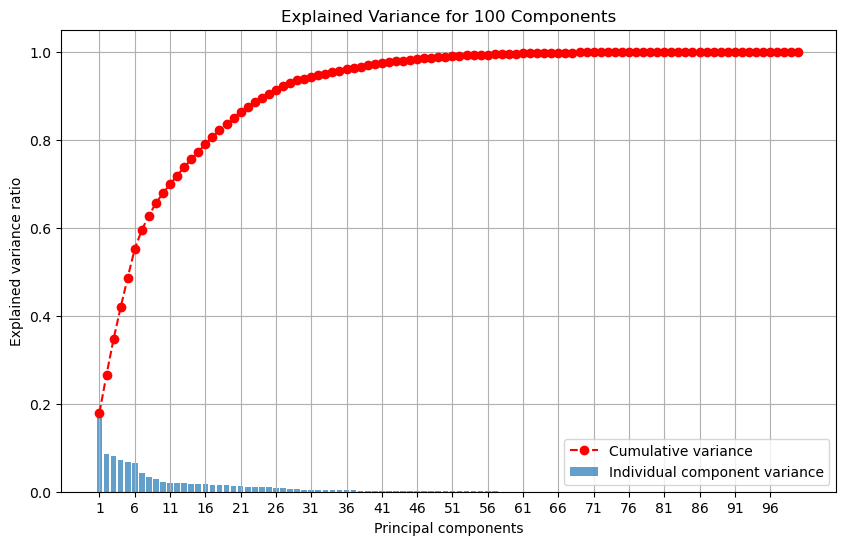

The number of components is 5. 

The variance explained is 0.486705286548877. 

The number of components is 10. 

The variance explained is 0.6785873970355932. 

The number of components is 15. 

The variance explained is 0.7729516964574246. 

The number of components is 20. 

The variance explained is 0.8494469635577996. 

The number of components is 25. 

The variance explained is 0.9046543279723523. 



In [22]:
pca_df_train, pca_df_test = train_test_split(stationary_data, df.index)
initial_PCA_scree(pca_df_train, TARGET)
for component in np.arange(5, 26, 5):
    _ = apply_PCA(pca_df_train, TARGET, n_components=component)

The scree plot indicates that the first 5 to 10 components contribute significantly to the total variance, while beyond 20 components, the curve flattens out. Applying PCA to a time series dataset for feature selection helps reduce dimensionality by capturing the most important variance, simplifying complex time series data, removing noise, improving model training speed, and avoiding multicollinearity—especially for highly correlated time-based features.

Furthermore, applying PCA without cross-validation can be more efficient, as PCA is unsupervised and focuses solely on maximizing variance rather than prediction accuracy. By fitting PCA on the entire dataset, we ensure a consistent transformation across all splits, avoiding the repetitive, computationally expensive process of refitting PCA during every fold of cross-validation. This approach maintains consistency and reduces computational overhead, particularly when the primary goal is dimensionality reduction rather than fine-tuning the model based on predictive power.

# 4.0 Final Notes

After experimenting with XGBoost Regressor and Lasso Regularization for feature selection, neither approach performed satisfactorily. Therefore, we will proceed with Principal Component Analysis (PCA), reducing our dataset to 20 components for the final model fitting process. This approach will help reduce the redundancy in the data, especially considering the highly correlated features identified earlier.

In future projects, we could improve the handling of time series data when using both XGBoost and Lasso. This would involve introducing more time series-specific features like lag variables for the weather features, or rolling averages, to better capture temporal patterns that may not have been detected in the current model. By treating the data with more care as a time series, we could potentially improve the feature selection process and overall performance.

Additionally, while we used TimeSeriesSplit for cross-validation, we might improve results by applying a custom cross-validation approach. This could involve manually splitting and shuffling the training data, which could help mitigate overfitting that was observed even with 10-fold cross-validation. We should also incorporate early stopping for the XGBoost Regressor to prevent unnecessary iterations when performance plateaus. Early stopping, combined with a validation set, could help avoid overfitting and yield more generalizable models.

Lastly, for future hyperparameter tuning, we could extend the search space for XGBoost, such as exploring deeper trees, smaller learning rates, and optimizing regularization parameters. For Lasso, experimenting with different scaling methods or switching to ElasticNet, which combines L1 and L2 regularization, could lead to better results. These adjustments could help refine the feature selection process and improve model performance if more time and resources were available.